<a href="https://colab.research.google.com/github/realtommypoole/AAI-511-Team-7-Compo-Identi/blob/main/Project_Report_Team7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Composer Classification Using Deep Learning
##Using Deep Learning Algorithms to Predict Composers

University of San Diego, Shiley-Marcos School of Engineering

Masters of Applied Artificial Intelligence

Professor Dr. Rod Albuyeh

Team 7 - Atul Prasad & Tommy Poole

Aug 11, 2025

Github Link:https://github.com/realtommypoole/AAI-511-Team-7-Compo-Identi

---
## Abstract

Deep learning networks can effectively classify composers based on featurs extracted from their songs. This project achieve over 80% accuracy across four composers, Bach, Mozart, Choping, and Beethoven by extracting similar musicial representations that humans might use to differentiate composers to train each model.

Keywords: Feature, Piano Roll, Note Sequence, pretty_midi, LSTM, CNN


---

##Introduction
Deep learning algorithms are effective in making accurate predictions using a variety of data types. This project utilizes music data, specifically MIDI files from four classical composers, Bach, Beethoven, Chopin, Mozart, in order to train deep learning networks, specifically Long Short Term Memory (LSTM) and Convolutional Neural Network (CNN) architectures, to accurately predict the composer of a given song.


##Dataset Description

The dataset used in this project originates from the MIDI Classic Music collection available on Kaggle (Fedorak, 2018). This dataset contains classical music compositions encoded in the Musical Instrument Digital Interface (MIDI) format. MIDI files are particularly well-suited for computational music analysis because they store symbolic representations of music—such as note pitch, duration, velocity (loudness), and timing—rather than raw audio waveforms.

MIDI files as an audio recording are  “about capturing the sound of the actual performance. MIDI recording or ‘sequencing’ is about capturing the actual notes of the performance” (Roland, n.d.). Extracting key features from these files, similar to the kinds of features a human would use to identify a unique composer, such as “musical complexity in the melodic line, harmonies, chord progressions, polyrhythm, variations in tempo, the use of counterpoint, ostinato, pedal point, the use of certain stylistic cadences, the selection of instruments, and changes in time and key signatures, and overall structure (sonata form, fugue, dance, etc)” is a critical element of data processing (Fedorak, 2018).

In order to handle MIDI files, a python library, “pretty_midi”. Introduced in 2014, is for “creating, manipulating and analyzing MIDI files. It is intended to make the most common operations applied to MIDI data as straightforward and simple as possible” (Raffel, 2014). This library was utilized extensively to manipulate the data and extract critical features used to train both models.

##Methodology

The methodology outline followed seven steps.

1. **Data Collection:** Data was downloaded from Kaggle (Fedorak, 2018).
2. **Data Preprocessing:** Extensive processing was required to extract the files from zipped folders and to convert the musical scores into a format suitable for the deep learning models.
3. **Feature Extraction:** Features such as notes, chords, key, note sequence, and many more were extracted from the MIDI files using the python pretty_midi library.
4. **Model Building:** Each model was developed and tuned to classify the musical scores according to the composer.
5. **Model Training:** Each built model was trained with the procssed features over numerous epochs.
6. **Model Evaluation:** Several evaluation metrics from the SciKit Learn library were leverated to evaluate the performance of each model, including accuracy, precision, and recall metrics.
7. **Model Optimization:** Each model was iteratively optimized, including improved data processing and hyper parameter tunnig to optimize perfomance.

___

Given the complexity of each model, the project included a data processing, feature extraction, model building, training, and evaluation portion with each model in addition to the intial preprocessing.

#**Data Collection**

Data Collection & Preprocessing are slightly blended in this section which includes:

* Download Python libraries
* Define key variables, and universal random seed for reproducability
* File download & processing, including unzipping

In [1]:
#Install Required Python Libraries quietly to reduce printout
!pip install kaggle -q
!pip install pretty_midi -q

In [2]:
#Import Key Libraries

#Standard Libraries
import os
import re
import ast
import random
import shutil
import zipfile
from zipfile import ZipFile
import warnings
from itertools import cycle

#Third-Party Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import mido
import pretty_midi
import pretty_midi as pm
import kagglehub as kagglehub

#Scikit-learn
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_curve, auc,
    roc_auc_score, average_precision_score, precision_recall_curve,
    RocCurveDisplay, top_k_accuracy_score
)

#TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


In [3]:
#Set desired file path
IS_GOOGLE_COLAB = False #Determines if running in cloud, or locally, dynamically adjusts storage
COMPOSERS = ['Bach', 'Beethoven', 'Chopin', 'Mozart'] #Defines specific composers to store and predict
DATASET_ID = "blanderbuss/midi-classic-music" #Kaggle data identifier
MIDI_DATA_DIR = '/content/midi_data' #Specify storage location
DESTINATION_DIR = "/tmp" #Specify storage location
SOURCE_DATA_DIR = DESTINATION_DIR #Specify storage location
SUPPORTED_EXT = ['.mid', '.midi'] #Ensure only .mid and .midi are processed

if IS_GOOGLE_COLAB == False:
    MIDI_DATA_DIR = os.path.join(os.getcwd(), 'midi_data')

In [4]:
#Set universal random seed for codeset for reproducibility
SEED = 42

def set_random_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_random_seed(SEED)

**NOTE:** The below codeblock is useful in case of user is running the code multiple times. This will get the latest updated data and be in sync with any change in source data over the time.

In [5]:
# ----------------------------------
#Function: Delete a folder and all its contents
# ----------------------------------
def delete_folder_recursive(folder_path):

    if os.path.exists(folder_path):
        try:
            shutil.rmtree(folder_path)
            print(f" Deleted folder and its contents: {folder_path}")
        except Exception as e:
            print(f"[ERROR] Failed to delete {folder_path}: {e}")
    else:
        print(f"[INFO] Folder does not exist: {folder_path}")

#Execute function
delete_folder_recursive("/content/midi_data")

 Deleted folder and its contents: /content/midi_data


## Data Download
This code block downloads the dataset from Kaggle using kagglehub, copies it into the specified local directory (DESTINATION_DIR). Extracts all .zip archives, including nested zips, ensuring the deepest levels of compressed data are accessible, and then organizes MIDI files into composer-specific folders.

In [6]:
# -------------------------------
#Function: Download Dataset via KaggleHub
# -------------------------------
def download_dataset(dataset_id):
    # Print the dataset being downloaded
    print(f"Downloading dataset: {dataset_id}")
    # Use KaggleHub API to download the dataset to a temporary location
    dataset_path = kagglehub.dataset_download(dataset_id)
    # Notify user of the download location
    print(f"Dataset downloaded to temporary path: {dataset_path}")
    return dataset_path

# -------------------------------
#Function: Copy Dataset to Destination
# -------------------------------
def copy_dataset(source_path, destination_path):
    # Create destination folder if it does not exist
    if not os.path.exists(destination_path):
        os.makedirs(destination_path)
        print(f"Created destination folder: {destination_path}")

    try:
        # Copy entire dataset directory to destination (allowing overwrite)
        shutil.copytree(source_path, destination_path, dirs_exist_ok=True)
        print(f"Dataset copied from '{source_path}' to '{destination_path}'")
    except Exception as e:
        print(f"[ERROR] Could not copy dataset: {e}")

# ----------------------------------
#Function: Create base output folder and composer folders
# ----------------------------------
def create_composer_folders(base_dir, composers):
    # Ensure base output directory exists
    os.makedirs(base_dir, exist_ok=True)
    # Create subfolder for each composer
    for composer in composers:
        composer_dir = os.path.join(base_dir, composer)
        os.makedirs(composer_dir, exist_ok=True)

# ----------------------------------
#Function: Recursively extract all .zip files in a directory
# ----------------------------------
def extract_all_nested_zips(base_path):
    # Traverse all directories and files within base_path
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.lower().endswith('.zip'):
                zip_path = os.path.join(root, file)
                extract_path = os.path.splitext(zip_path)[0]
                # Extract contents of the ZIP file
                try:
                    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                        zip_ref.extractall(extract_path)
                        #print(f"Extracted: {zip_path} -> {extract_path}")
                except zipfile.BadZipFile:
                    print(f"[WARNING] Skipped invalid ZIP: {zip_path}")
                    continue
                except Exception as e:
                    print(f"[ERROR] Failed to extract {zip_path}: {e}")
                    continue
                # Recursively extract deeper levels
                extract_all_nested_zips(extract_path)

# ----------------------------------
#Function: Copy .midi files to composer folders
# ----------------------------------
def copy_midi_files_to_composer_folders(source_dir, target_dir, composers):
    # Walk through all files and directories in the source
    for root, dirs, files in os.walk(source_dir):
        for file in files:
            # Process only .mid or .midi files
            if file.lower().endswith('.mid') or file.lower().endswith('.midi'):
                full_path = os.path.join(root, file)
                for composer in composers:
                    if composer.lower() in full_path.lower():
                        destination = os.path.join(target_dir, composer, file)
                        try:
                            shutil.copy2(full_path, destination)
                            #print(f"Copied: {full_path} -> {destination}")
                        except Exception as e:
                            print(f"[ERROR] Failed to copy {full_path}: {e}")
                        break

# ----------------------------------
#Function: Orchestrator function
# ----------------------------------
def organize_midi_data():
    # Create output structure
    create_composer_folders(MIDI_DATA_DIR, COMPOSERS)

    # Extract all ZIPs (even nested)
    extract_all_nested_zips(SOURCE_DATA_DIR)

    # Copy relevant .midi files to target composer folders
    copy_midi_files_to_composer_folders(SOURCE_DATA_DIR, MIDI_DATA_DIR, COMPOSERS)

# ----------------------------------
#Function: Print summary of .mid/.midi files per composer
# ----------------------------------
def print_midi_file_summary(composer_dir, composers):
    summary = {}

    for composer in composers:
        folder_path = os.path.join(composer_dir, composer)
        count = 0

        # Count .mid and .midi files only
        for file in os.listdir(folder_path):
            ext = os.path.splitext(file)[1].lower()
            if ext in SUPPORTED_EXT:
                count += 1

        summary[composer] = count

    print("\n MIDI File Summary per Composer:")
    print("----------------------------------")
    for composer, count in summary.items():
        print(f"{composer}: {count} files")

# -------------------------------
#Function: Full Setup Pipeline
# -------------------------------
def setup_dataset():
    source = download_dataset(DATASET_ID)
    copy_dataset(source, DESTINATION_DIR)
    organize_midi_data()

#Execute functions for data download and organization
setup_dataset()
print_midi_file_summary(MIDI_DATA_DIR, COMPOSERS)

Dataset downloaded to temporary path: /kaggle/input/midi-classic-music
Dataset copied from '/kaggle/input/midi-classic-music' to '/tmp'

 MIDI File Summary per Composer:
----------------------------------
Bach: 1050 files
Beethoven: 220 files
Chopin: 138 files
Mozart: 259 files


# **Data Pre-Processing & Feature Extraction**

While conceptually seperate steps outlined in the methodology above, data pre-processing and feature extraction are blended in this section as the files are processed, and prepared for modeling.

A critical issue this data, and the types of features needed for sequential modeling, is storage management. This section includes code blocks designed to minimize RAM usage so that this code can run in a Google CoLab environment.

In order to minimize MIDI files are

Discovers, labels, and indexes MIDI files for four classes (Bach, Beethoven, Chopin, Mozart):

It recursively scans base_dir for files with extensions in supported_ext.

It assigns each file to the first composer whose name appears in the file path (case‑insensitive).

For supervised learning, we require pairs (𝑥𝑖,𝑦𝑖) where  𝑥𝑖 is a MIDI file path and 𝑦𝑖∈{Bach,Beethoven,Chopin,Mozart}, which is the canonical input to LSTM

In [7]:
# -------------------------------
#Function: Get Composer MIDIs
# -------------------------------
#Finds MIDI file paths for selected composers in the downloaded files and return a dataframe a a dict mapping composers to their files.
def get_composer_midis(base_dir, composers, supported_ext=('.mid', '.midi')):
    matched_paths = []

    for root, dirs, files in os.walk(base_dir):
        for f in files:
            file_path = os.path.join(root, f)
            if file_path.lower().endswith(supported_ext):
                for composer in composers:
                    if composer.lower() in file_path.lower():
                        matched_paths.append({'filepath': file_path, 'composer': composer})
                        break  # Only assign first matching composer

    #Create DataFrame from filepaths
    df = pd.DataFrame(matched_paths)
    pd.set_option('display.max_colwidth', None)

    #Drop any rows where composer is not found (shouldn't happen, but kept for safety)
    df = df.dropna(subset=['composer'])

    #Collect filepaths for each composer
    composer_files = {composer: df[df['composer'] == composer]['filepath'].tolist() for composer in composers}

    #Print stats to validate
    for composer, files in composer_files.items():
        print(f"{composer}: {len(files)} files")

    return df, composer_files

#Execute function defined above
df, composer_files = get_composer_midis(MIDI_DATA_DIR, COMPOSERS)

Bach: 1050 files
Beethoven: 220 files
Chopin: 138 files
Mozart: 259 files


In [8]:
#Review Dataframe to validate format
df.head()

,filepath,composer
0,/content/midi_data/Mozart/K317 Coronation Mass 6mov.mid,Mozart
1,/content/midi_data/Mozart/K309 Piano Sonata n10 2mov.mid,Mozart
2,/content/midi_data/Mozart/K608 Fantasia for Mechanical Organ.mid,Mozart
3,/content/midi_data/Mozart/Symphony n41 K551 2mov ''Jupiter''.mid,Mozart
4,/content/midi_data/Mozart/Piano Sonata n07 K309.mid,Mozart


In [9]:
def balance_bach_dataset(df, bach_name='Bach', seed=42, bach_frac=0.6, others_extra_frac=0.66):
    rng = np.random.default_rng(seed)

    # 1) Downsample Bach
    df_bach = df[df['composer'] == bach_name].sample(frac=bach_frac, random_state=seed)

    # 2) Oversample each other composer
    other_composers = df[df['composer'] != bach_name]
    oversampled_others = []

    for composer, group in other_composers.groupby('composer'):
        # Always take all originals
        base = group

        # Sample the extra 66%
        extra_count = int(len(group) * others_extra_frac)
        if extra_count > 0:
            extra = group.sample(n=extra_count, replace=True, random_state=seed)
            oversampled_group = pd.concat([base, extra])
        else:
            oversampled_group = base

        oversampled_others.append(oversampled_group)

    df_others_oversampled = pd.concat(oversampled_others, ignore_index=True)

    # 3) Combine Bach subset and oversampled others
    df_balanced = pd.concat([df_bach, df_others_oversampled], ignore_index=True)

    # 4) Shuffle
    df_balanced = df_balanced.sample(frac=1.0, random_state=seed).reset_index(drop=True)

    # 5) Debug info
    print("Counts per composer after balancing:")
    print(df_balanced['composer'].value_counts())

    return df_balanced


df_balanced = balance_bach_dataset(
    df,
    bach_name='Bach',
    seed=SEED,
    bach_frac=0.6,
    others_extra_frac=0.7
)

Counts per composer after balancing:
composer
Bach         630
Mozart       440
Beethoven    374
Chopin       234
Name: count, dtype: int64


**NOTE**

During optimization, we adjusted the balancing mutliple times. This fraction delivered the best results over multiple different adjustments spanning from no balancing to reducing all files to the same number, to significantly reducing Bach files.

By reducing Bach files by randomly selecting 60% of the total, and nearly doubling all other composers, we were able to optimize performance of both models below.

Other techniques for rebalancing such as weighting were included in the CNN model preprocessing speciifcally, however expiriementation with the LSTM did not achieve performance improvement with weighting techniques.

In [10]:
# -------------------------------
#Function: Sanatize MIDI Files
# -------------------------------
# Sanitize MIDI files to normalize meta events and skip problematic files
def sanitize_midi(input_path, output_path=None):
    #Wrap I/O and parsing in a protective try/except to handle malformed files
    try:
        #Parse the MIDI file into a Mido MidiFile object (raises if header is invalid)
        mid = mido.MidiFile(input_path)
        #Accumulate meta events that should live globally (track 0)
        global_events = []
        #Initialize a new track list with an empty track 0 placeholder
        new_tracks = [mido.MidiTrack()]
        #Iterate through original tracks with their index to detect track 0 vs others
        for i, track in enumerate(mid.tracks):
            #Create a fresh track to hold sanitized events from this original track
            new_track = mido.MidiTrack()
            #Iterate through all messages in this track
            for msg in track:
                #Identify timing/key signature meta that must live in track 0 for many tools
                if msg.is_meta and msg.type in ['set_tempo', 'key_signature', 'time_signature']:
                    #If this is NOT the global track (i != 0), defer to global_events
                    if i != 0:
                        global_events.append(msg)
                    else:
                        #If already in track 0, keep it in the current (new) track
                        new_track.append(msg)
                else:
                    #All other messages are copied as‑is to this track’s sanitized version
                    new_track.append(msg)
            #For non‑zero tracks, append the sanitized track to the track list
            if i != 0:
                new_tracks.append(new_track)
        #After processing all tracks, append the collected global meta to track 0
        new_tracks[0].extend(global_events)
        #Replace the MidiFile’s tracks with the sanitized list
        mid.tracks = new_tracks
        #Choose output destination: overwrite input by default or write to output_path if given
        output = output_path or input_path
        #Persist the sanitized MIDI back to disk
        mid.save(output)
    except Exception as e:
        if 'KeySignatureError' in str(e) or 'Could not decode key' in str(e):
            print(f"[SKIP] {input_path}: {e}")
        else:
            print(f"[ERROR] {input_path}: {e}")
        raise #Ensure calling code also sees error for handling

successful_paths = []
failed_paths = []

for path in tqdm(df['filepath'], desc="Sanitizing MIDI files"):
    try:
        sanitize_midi(path)
        successful_paths.append(path)  #Only add if sanitize did NOT raise an exception
    except Exception as e:
        failed_paths.append(path)      #Log failures for later inspection
        tqdm.write(f"[SKIP/ERROR] {path}: {e}")

Sanitizing MIDI files:   6%|▌         | 100/1667 [00:19<02:45,  9.47it/s]

[SKIP] /content/midi_data/Mozart/K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2
[SKIP/ERROR] /content/midi_data/Mozart/K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2


Sanitizing MIDI files:  17%|█▋        | 289/1667 [00:43<01:07, 20.39it/s]

[ERROR] /content/midi_data/Chopin/chopin7.mid: MThd not found. Probably not a MIDI file
[SKIP/ERROR] /content/midi_data/Chopin/chopin7.mid: MThd not found. Probably not a MIDI file


Sanitizing MIDI files:  97%|█████████▋| 1611/1667 [02:14<00:04, 12.35it/s]

[SKIP] /content/midi_data/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255
[SKIP/ERROR] /content/midi_data/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255


Sanitizing MIDI files: 100%|██████████| 1667/1667 [02:28<00:00, 11.22it/s]


**NOTE**

This code sanitizes each MIDI file, normalizing each MIDI so that timing/key metadata (set_tempo, key_signature, time_signature) live in track 0, a common convention that prevents downstream parsers from choking, while keeping all other messages in their original (non‑zero) tracks. Files that are not valid MIDI files (e.g., missing MThd) or have unparseable key signatures are skipped, not fatal to the batch.

This transformation reduces schema variance prior to feature extraction, thereby stabilizing statistical properties that the LSTM will learn.





In [11]:
#Print length of successful and failed files for validation
print("Total df Before Sanitation:", len(df))
print("Successful Files:", len(successful_paths))
print("Failed Files:", len(failed_paths))
#Update df with successful_paths only
df = df[df['filepath'].isin(successful_paths)]

#Print length of df to vaildate
print("Total df After Sanitation:", len(df))

Total df Before Sanitation: 1667
Successful Files: 1664
Failed Files: 3
Total df After Sanitation: 1664


##Primary Functions for Feature Extraction

In [12]:
# -------------------------------
#Function: Extract Statistical Features
# -------------------------------
def compute_statistical_midi_features(midi_file_path):
    midi_obj = pm.PrettyMIDI(midi_file_path) #Load the MIDI file using PrettyMIDI for feature extraction

    #Extract all note events from non-drum instruments (focus on melodic/harmonic elements)
    note_list = [note for instr in midi_obj.instruments if not instr.is_drum for note in instr.notes]

    #Sort notes by their start time to compute inter-onset intervals (IOI) correctly
    note_list.sort(key=lambda n: n.start)

    #Extract pitches from notes (MIDI note numbers, e.g., 60 = Middle C)
    pitch_values = [note.pitch for note in note_list]

    #Extract note durations (end time - start time) to analyze rhythm patterns
    duration_values = [note.end - note.start for note in note_list]

    #Extract velocities (note intensity, related to loudness or emphasis)
    velocity_values = [note.velocity for note in note_list]

    #Compute inter-onset intervals (IOI): time difference between consecutive note starts
    iois = [note_list[i].start - note_list[i-1].start for i in range(1, len(note_list))]

    #Extract tempo (beats per minute). Use first tempo value or default to 120 BPM if missing
    tempo_changes = midi_obj.get_tempo_changes()[1]
    tempo_value = tempo_changes[0] if tempo_changes.size else 120

    #Safely extract key signature (e.g., number of sharps/flats) or None if unavailable
    try:
        key_signature = midi_obj.key_signature_changes[0].key_number if midi_obj.key_signature_changes else None
    except Exception:
        key_signature = None

    #Safely extract time signature (e.g., 4/4, 3/4). Return None if not found
    try:
        time_sig_obj = midi_obj.time_signature_changes[0] if midi_obj.time_signature_changes else None
        time_signature = f"{time_sig_obj.numerator}/{time_sig_obj.denominator}" if time_sig_obj else None
    except Exception:
        time_signature = None

    #Return all extracted features in a dictionary for use in ML models
    return {
        #Total duration of the MIDI piece in seconds
        #Useful to capture overall length and pacing (some composers write longer pieces)
        "total_duration": midi_obj.get_end_time(),

        #Number of instruments used (polyphonic richness can differ by composer)
        "instrument_count": len(midi_obj.instruments),

        #Total number of notes in the piece (measures overall activity and complexity)
        "total_notes": len(pitch_values),

        #Note density: number of notes per second (captures speed & ornamentation style)
        "note_density": len(pitch_values) / midi_obj.get_end_time() if midi_obj.get_end_time() > 0 else None,

        #Average velocity of notes (represents expressive dynamics; some composers write more nuanced dynamics)
        "velocity_mean": np.mean(velocity_values) if velocity_values else None,

        #Minimum pitch (lowest note). Can reveal usage of bass notes or registers
        "min_pitch": min(pitch_values) if pitch_values else None,

        #Maximum pitch (highest note). Useful for range analysis between composers
        "max_pitch": max(pitch_values) if pitch_values else None,

        #Average pitch (overall register of the piece; e.g., Chopin uses higher average pitch in solos)
        "avg_pitch": np.mean(pitch_values) if pitch_values else None,

        #Most frequently occurring pitch (mode of pitch distribution; shows melodic patterns or drones)
        "common_pitch": max(set(pitch_values), key=pitch_values.count) if pitch_values else None,

        #Mean note duration (longer notes imply slower melodies, shorter = faster ornamentation)
        "mean_duration": np.mean(duration_values) if duration_values else None,

        #Standard deviation of note durations (measures rhythmic variation or stability)
        "std_duration": np.std(duration_values) if len(duration_values) > 1 else 0,

        #Mean inter-onset interval (average time gap between notes; relates to tempo feel and spacing)
        "mean_ioi": np.mean(iois) if iois else None,

        #Std deviation of IOI (rhythmic complexity: stable rhythm vs expressive rubato)
        "std_ioi": np.std(iois) if iois else None,

        #Tempo in BPM (can reflect stylistic differences in tempo choices)
        "tempo": tempo_value,

        #Key signature (numeric representation; important for harmonic profiling)
        "key_signature": key_signature,

        #Time signature (e.g., 4/4, 3/4; rhythmic structure of the piece)
        "time_signature": time_signature
    }

# -------------------------------
#Function: Extract Sequential Features for LSTM
# -------------------------------
def compute_sequence_midi_features(midi_file_path, max_length=5000):
    #Load the MIDI file using PrettyMIDI for sequence extraction
    midi_obj = pm.PrettyMIDI(midi_file_path)

    #Extract all non-drum notes from all instruments to focus on melody/harmony
    #Drums are excluded because they don't carry pitch information
    notes = sorted([n for i in midi_obj.instruments if not i.is_drum for n in i.notes], key=lambda n: n.start)

    #Create note sequence matrix with columns:
    #[start_time, pitch, duration, velocity]
    #This sequence preserves the order of musical events.
    note_sequence_matrix = np.array([[n.start, n.pitch, n.end - n.start, n.velocity] for n in notes])

    #Extract piano roll matrix (shape: 128 pitches x time frames)
    #Each cell represents note intensity at a given pitch and time
    #Used as input for CNNs treating the piano roll as an image
    piano_roll_matrix = midi_obj.get_piano_roll(fs=50)

    #Pad or crop the piano roll to a consistent length (max_length = 5000 frames)
    #Padding ensures all sequences are the same length, required for CNN input
    piano_roll_matrix = np.pad(piano_roll_matrix, ((0, 0), (0, max(0, max_length - piano_roll_matrix.shape[1]))))[:, :max_length]

    #Extract chroma matrix (12 pitch classes x time frames)
    #Summarizes notes into octave-invariant pitch classes (C, C#, D, ..., B)
    #Captures harmonic information useful for composer style analysis
    chroma_matrix = midi_obj.get_chroma(fs=50)

    #Pad or crop chroma matrix to max_length to ensure consistent input size
    chroma_matrix = np.pad(chroma_matrix, ((0, 0), (0, max(0, max_length - chroma_matrix.shape[1]))))[:, :max_length]

    #Initialize onset matrix (same shape as piano roll)
    onset_matrix = np.zeros_like(piano_roll_matrix) #This represents note onsets specifically (when each note starts)


    #Populate the onset matrix: set velocity at the note's starting time index
    #This feature captures temporal structure and is important for rhythm modeling
    for n in notes:
        idx = int(n.start * 50)  #Convert start time to frame index based on 50 Hz resolution
        if idx < max_length:
            onset_matrix[n.pitch, idx] = n.velocity

    #Compute rhythm array: a 1D binary array indicating whether any note starts at each time step
    #Summarizing onset events across all pitches into a single rhythm vector
    #Useful for capturing global rhythmic patterns irrespective of pitch
    rhythm_array = (np.sum(onset_matrix, axis=0, keepdims=True) > 0).astype(int)

    #Return the extracted sequence-based features as a dictionary
    return {
        #The raw sequence of musical notes, useful for LSTM input
        "note_seq": note_sequence_matrix,

        #The piano roll image-like matrix, used for CNN-based classification
        "piano_roll": piano_roll_matrix,

        #Chroma feature matrix (12 pitch classes), useful for tonal/harmonic analysis
        "chroma": chroma_matrix,

        #Onset matrix indicating exactly when each note starts
        "onset_pattern": onset_matrix,

        #Rhythm pattern (1D), capturing time steps where any note starts
        "rhythm_pattern": rhythm_array
    }

## Feature Extraction With Low RAM Usage

In [13]:
#Set persistent base directory
os.makedirs(MIDI_DATA_DIR, exist_ok=True)

#CSV for extracted features
csv_path = os.path.join('features.csv')

#Dedicated directory for array storage
ARRAY_SAVE_DIR = os.path.join(MIDI_DATA_DIR, 'saved_arrays')
os.makedirs(ARRAY_SAVE_DIR, exist_ok=True)

#Clear previous CSV if starting over
if os.path.exists(csv_path):
    os.remove(csv_path)

In [14]:
# -------------------------------
#Function: Low RAM Feature Extraction Call
# -------------------------------
#Extracts MIDI features in a low-RAM way by flushing results incrementally to CSV
def low_ram_feature_extraction(
    df,
    csv_path,
    array_save_dir,
    compute_statistical_midi_features,
    compute_sequence_midi_features,
    flush_interval=100
):
    os.makedirs(array_save_dir, exist_ok=True)
    results = []

    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Extracting features"):
        midi_file = row['filepath']
        composer_label = row['composer']

        try:
            stat_features = compute_statistical_midi_features(midi_file)
            seq_features = compute_sequence_midi_features(midi_file)

            # Save note_seq array as .npy and store its path
            note_seq = seq_features.get('note_seq')
            note_seq_path = None
            if isinstance(note_seq, np.ndarray):
                array_filename = f"{os.path.splitext(os.path.basename(midi_file))[0]}_note_seq_{idx}.npy"
                array_filepath = os.path.join(array_save_dir, array_filename)
                np.save(array_filepath, note_seq)
                note_seq_path = array_filepath
                del seq_features['note_seq']

            combined = {
                **stat_features,
                **seq_features,
                "note_seq_path": note_seq_path,
                "composer": composer_label,
                "file": midi_file,
            }
            results.append(combined)

            #Flush to CSV every flush_interval
            if len(results) % flush_interval == 0:
                pd.DataFrame(results).to_csv(
                    csv_path,
                    mode='a',
                    header=not os.path.exists(csv_path),
                    index=False
                )
                results = []

        except Exception as e:
            print(f"[ERROR] Failed to process {midi_file}: {e}")

    #Save any remaining records
    if results:
        pd.DataFrame(results).to_csv(
            csv_path,
            mode='a',
            header=not os.path.exists(csv_path),
            index=False
        )

In [15]:
#Call defined function above to extract features
low_ram_feature_extraction(
    df=df,
    csv_path="features.csv",
    array_save_dir="note_arrays",
    compute_statistical_midi_features=compute_statistical_midi_features,
    compute_sequence_midi_features=compute_sequence_midi_features,
    flush_interval=100
)


Extracting features: 100%|██████████| 1664/1664 [11:46<00:00,  2.35it/s]


In [16]:
#Convert features from csv to python DataFrame and print features for validation
features_df = pd.read_csv(csv_path)
df_copy = features_df.copy()
print(features_df.columns)

Index(['total_duration', 'instrument_count', 'total_notes', 'note_density',
       'velocity_mean', 'min_pitch', 'max_pitch', 'avg_pitch', 'common_pitch',
       'mean_duration', 'std_duration', 'mean_ioi', 'std_ioi', 'tempo',
       'key_signature', 'time_signature', 'piano_roll', 'chroma',
       'onset_pattern', 'rhythm_pattern', 'note_seq_path', 'composer', 'file'],
      dtype='object')


##Exploratory Data Analysis

The below segment of the preprocessing and feature extraction, visualizes the information for evaluation, before finalizing features for model training.

In [17]:
#Print overall info for review
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1664 entries, 0 to 1663
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   total_duration    1664 non-null   float64
 1   instrument_count  1664 non-null   int64  
 2   total_notes       1664 non-null   int64  
 3   note_density      1623 non-null   float64
 4   velocity_mean     1623 non-null   float64
 5   min_pitch         1623 non-null   float64
 6   max_pitch         1623 non-null   float64
 7   avg_pitch         1623 non-null   float64
 8   common_pitch      1623 non-null   float64
 9   mean_duration     1623 non-null   float64
 10  std_duration      1664 non-null   float64
 11  mean_ioi          1623 non-null   float64
 12  std_ioi           1623 non-null   float64
 13  tempo             1664 non-null   float64
 14  key_signature     47 non-null     float64
 15  time_signature    6 non-null      object 
 16  piano_roll        1664 non-null   object 


In [18]:
#Add a feature for note sequences to create numpy arrays from paths
#Initialize the 'note_seq' column with None
features_df['note_seq'] = None

# Iterate over rows with valid 'note_seq_path' and load arrays once
for idx, path in features_df['note_seq_path'].dropna().items():
    try:
        features_df.at[idx, 'note_seq'] = np.load(path)
    except Exception as e:
        print(f"Failed to load {path} at index {idx}: {e}")

# Print example loaded array and its type
print(features_df['note_seq'].iloc[0])  # Should print a numpy array
print(type(features_df['note_seq'].iloc[0]))  # Should print <class 'numpy.ndarray'>

[[  0.          65.           1.00833333  64.        ]
 [  0.          57.           0.21666667  49.        ]
 [  0.25        60.           0.22916667  54.        ]
 ...
 [182.          67.           0.53333333  90.        ]
 [182.          60.           0.49583333  90.        ]
 [182.          48.           0.47083333  78.        ]]
<class 'numpy.ndarray'>


In [19]:
print(features_df.columns) #Ensure note_seq is added

Index(['total_duration', 'instrument_count', 'total_notes', 'note_density',
       'velocity_mean', 'min_pitch', 'max_pitch', 'avg_pitch', 'common_pitch',
       'mean_duration', 'std_duration', 'mean_ioi', 'std_ioi', 'tempo',
       'key_signature', 'time_signature', 'piano_roll', 'chroma',
       'onset_pattern', 'rhythm_pattern', 'note_seq_path', 'composer', 'file',
       'note_seq'],
      dtype='object')


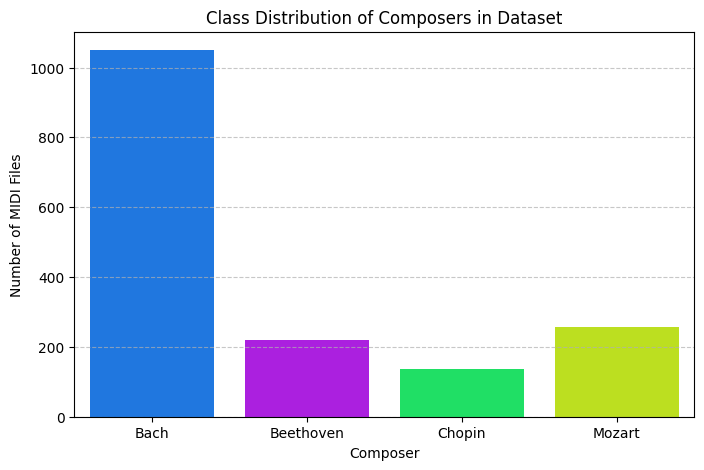

In [20]:
#Plot class distribution before splitting
plt.figure(figsize=(8, 5))

#Generate a distinct color for each composer
colors = sns.color_palette("hsv", len(COMPOSERS))  # or try "tab10", "Paired", etc.

#Create the countplot with the palette
sns.countplot(
    data=features_df,
    x='composer',
    hue='composer', #Assign hue same as x
    order=COMPOSERS,
    palette=colors,
    legend=False #Hide legend to avoid redundancy
)

plt.title("Class Distribution of Composers in Dataset")
plt.xlabel("Composer")
plt.ylabel("Number of MIDI Files")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Dataset Overview:
        total_duration  instrument_count   total_notes  note_density  \
count     1664.000000       1664.000000   1664.000000   1623.000000   
mean       208.711759          5.116587   3016.547476     12.990896   
std        288.488693          4.559316   4806.603019      7.890052   
min          0.000000          0.000000      0.000000      2.956724   
25%         36.923698          2.000000    336.000000      8.085309   
50%         96.000000          4.000000   1068.500000     10.504909   
75%        260.241667          5.000000   3598.000000     15.060850   
max       4482.375000         40.000000  46897.000000     69.022285   

       velocity_mean    min_pitch    max_pitch    avg_pitch  common_pitch  \
count    1623.000000  1623.000000  1623.000000  1623.000000   1623.000000   
mean       83.093406    35.396180    84.208872    62.960335     64.815773   
std        18.508729     6.370993     7.116617     3.057252      6.525295   
min        30.812865     9.000000

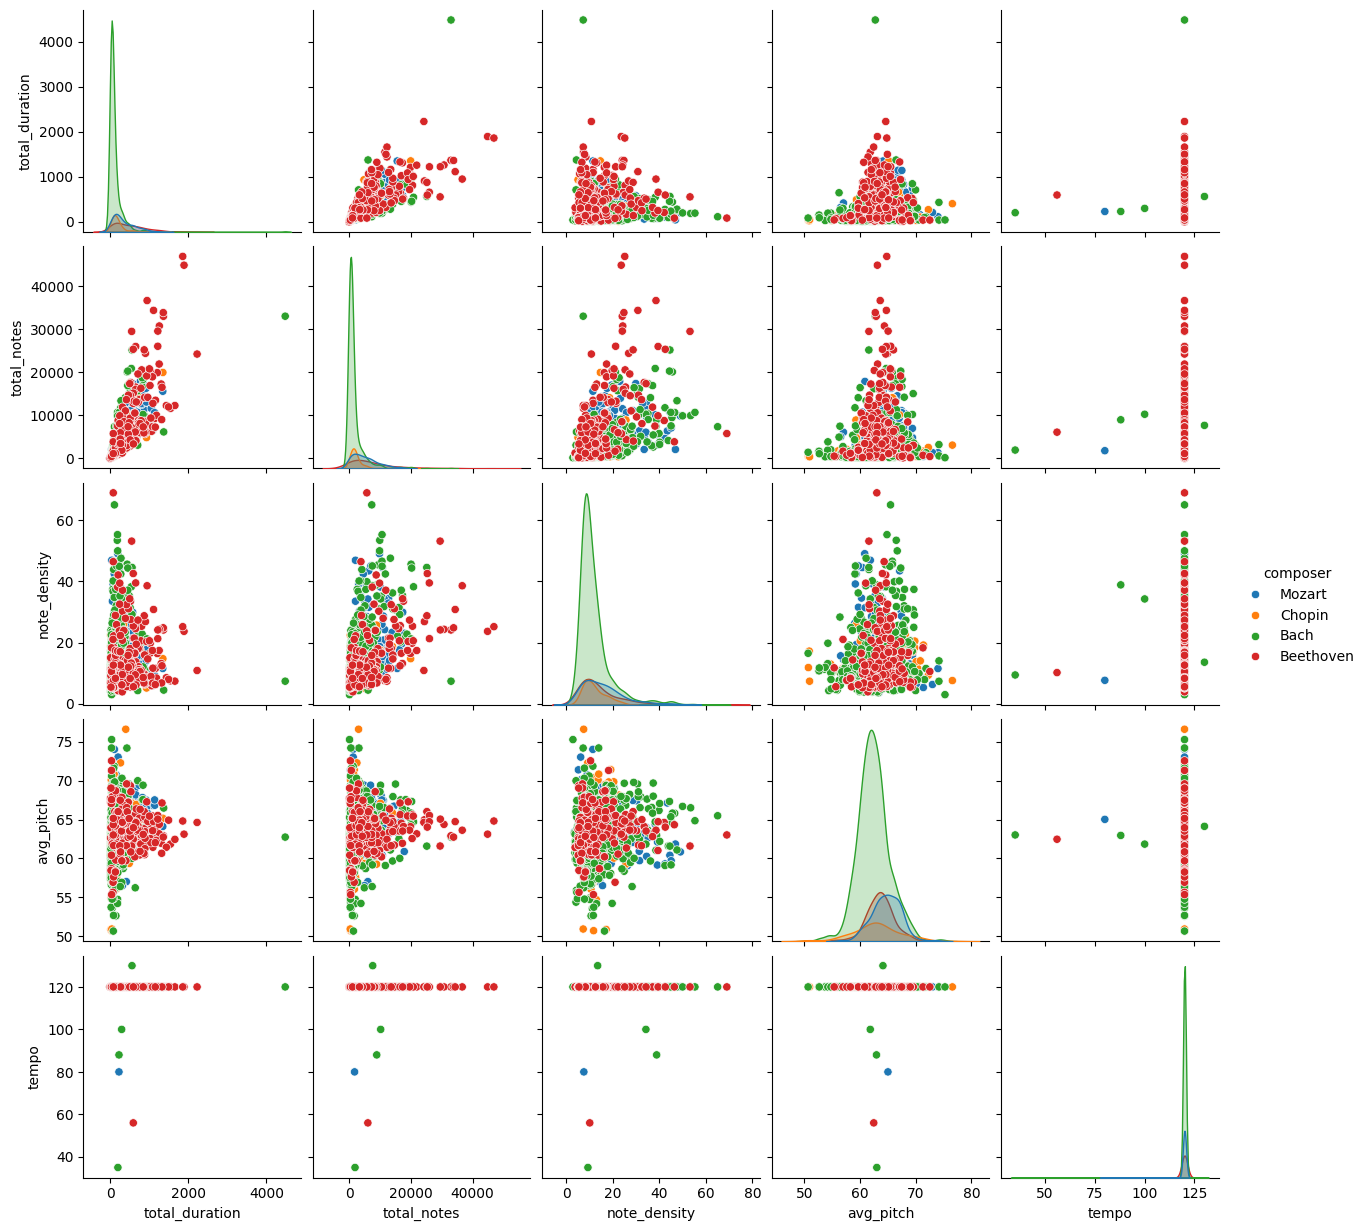

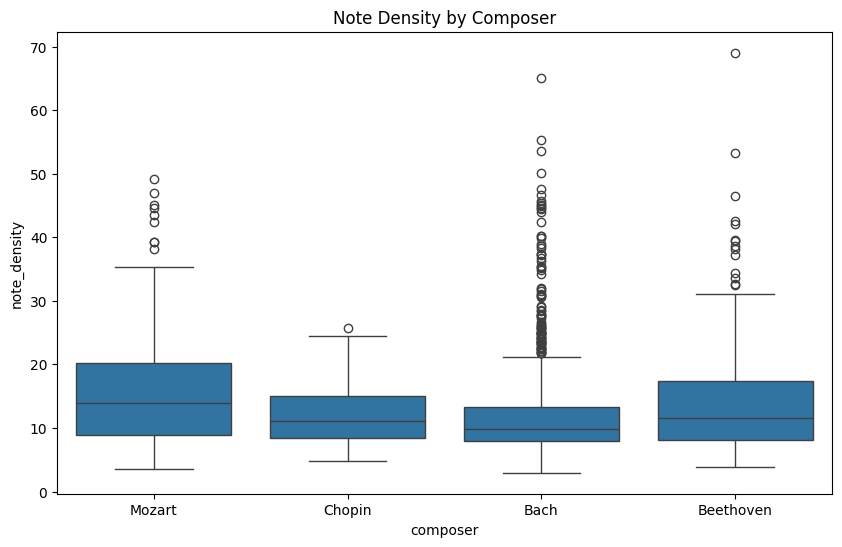

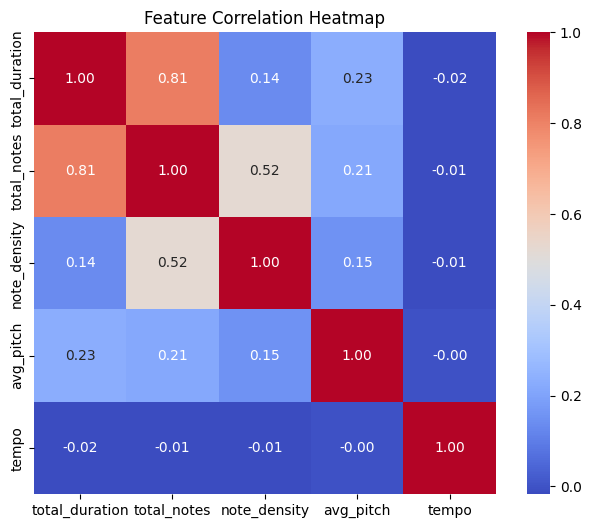

In [21]:
# -------------------------------
#Function: Exploratory Data Analysis
# -------------------------------

#Performs Exploratory Data Analysis (EDA) including pairplots, boxplots, and heatmaps
#Focuses only on scalar features for visualization

def run_exploratory_data_analysis(features_df):
    print("Dataset Overview:\n", features_df.describe()) #Print dataset summary statistics
    print("\nMissing Data Report:\n", features_df.isnull().sum()) #Print missing values in the dataset

    #Select numeric scalar features for visualization (no sequence arrays)
    scalar_df = features_df[['total_duration', 'total_notes', 'note_density', 'avg_pitch', 'tempo', 'composer']].copy()

    #Pairplot to see pairwise distributions per composer
    sns.pairplot(scalar_df, hue='composer', vars=['total_duration', 'total_notes', 'note_density', 'avg_pitch', 'tempo'])
    plt.show()

    #Boxplot of note density by composer
    plt.figure(figsize=(10,6))
    sns.boxplot(x='composer', y='note_density', data=scalar_df)
    plt.title("Note Density by Composer")
    plt.show()

    #Heatmap of feature correlations
    plt.figure(figsize=(8,6))
    sns.heatmap(scalar_df.drop(columns=['composer']).corr(), annot=True, cmap='coolwarm', fmt=".2f", square=True)

    plt.title("Feature Correlation Heatmap")
    plt.show()

#Call function above
run_exploratory_data_analysis(features_df)

##EDA Discussion

The average piece length in this dataset is ~243 seconds, with a widespread standard devaition of ~315 seconds, indicating variability in composition lengths. The average note density is ~13.44 notes per second, but with extreme outliers up to ~69 notes per second. The median tempo is around 120 beats per minute for most pieces, with small variation.the Key signature is very sparse with a total count of only 44 out of all 1200 plus pieces, so this statistic unreliable for analysis. Similarly, the time signature is extremely sparse, with only 5 total pieces including this datapoint.

As expected, the pairplot shows a strong positive relationship between "total_duration" and "total_notes", (r ≈ 0.81), as longer pieces would have more total notes. This is also true, though the correlation is moderated, (r ≈ 0.51), with "note_density" and total "total_notes"

Tempo is uncorrelated with other features (near zero), confirming it is independent in this dataset.

Considering the note density boxplot, Mozart tends to have slightly higher median note density than other composers.Bach shows the widest spread with many outliers, reflecting stylistic complexity and ornamentation. Chopin has a lower density median than Mozart and Beethoven but fewer extreme outliers.

Ovearll, the data suggests suggests that multivariate feature interactions may be more informative for classification than any single metric.

#**Model Building, Model Training, Evaluation, & Optimization**

## **LSTM - Model Building**

For each deep learning model, the model build, model training, and evaluation are handled in their own section. In addiiton, each model required speicific sequential data features which means each section also includes some preprocessing.

###LSTM Preprocessing - Note Sequences

LSTM models are designed to learn sequential information. Note sequences are sequential features extracted from the MIDI files, used to train complex patterns between each composer.

Note sequences are a list of encoded individual note events. A note event is a term used in MIDI and computational music to represent an individual musical note as it is played or written. If you read sheet music, a "note event" corresponds to one note on the page—the moment when a particular pitch begins, for a specific duration, at a certain velocity or loudness, and typically played by a particular instrument. The note sequences are variable-length 2D arrays where each row is a note and each column is a features, plus two additional global features added during optimization.

Since the data exhibits variability, the code below explore some of the specific elements of the "note_seq" features, so that correct preprocessing and tuning could extract optimal features for peak learning and perforamnce.

Number of valid sequences: 1623
Mean sequence length (number of notes): 3092.751078250154
Median sequence length 1137.0
Min sequence length: 83
Max sequence length: 46897


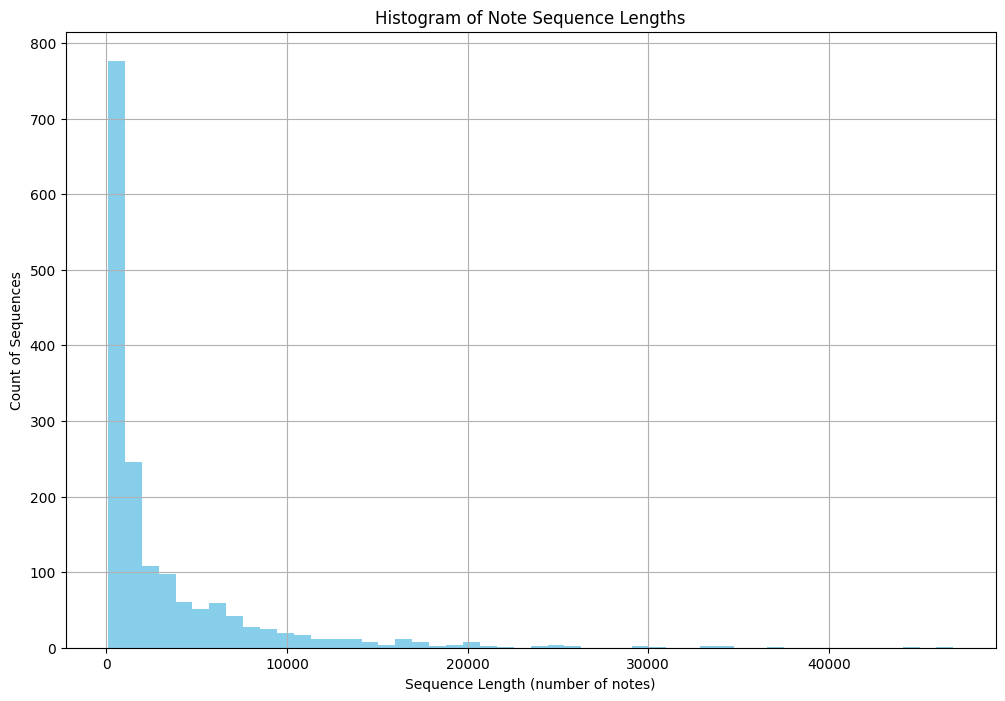

In [22]:
#Extract note sequences
note_seqs = features_df['note_seq']

#Keep only valid sequences of the correct shape
valid_note_seqs = [seq for seq in note_seqs if isinstance(seq, np.ndarray) and seq.ndim == 2 and seq.shape[1] == 4]

#Get the length (number of notes) for each sequence
seq_lengths = [seq.shape[0] for seq in valid_note_seqs]

#Compute statistics
mean_length = np.mean(seq_lengths) if seq_lengths else 0
median_length = np.median(seq_lengths) if seq_lengths else 0
min_length = np.min(seq_lengths) if seq_lengths else 0
max_length = np.max(seq_lengths) if seq_lengths else 0

print("Number of valid sequences:", len(seq_lengths))
print("Mean sequence length (number of notes):", mean_length)
print("Median sequence length", median_length)
print("Min sequence length:", min_length)
print("Max sequence length:", max_length)

#Ensure you are using the actual sequence length data you computed
seq_lengths = [seq.shape[0] for seq in valid_note_seqs]

#Plot histogram
plt.figure(figsize=(12, 8))
plt.hist(seq_lengths, bins=50, color='skyblue')
plt.title('Histogram of Note Sequence Lengths')
plt.xlabel('Sequence Length (number of notes)')
plt.ylabel('Count of Sequences')
plt.grid(True)
plt.show()

**NOTE**

The histogram and analysis reveals a highly skewed distribution, with most compositions containing relatively few notes and a small number of works exhibiting extremely large note counts. This informed the cutoff length for sequences below. Longer sequences were padded with 0s, and longer sequences were cut short. Finding the right balance to retain the best information, without over padding, or cutting to short, was a critical step.

###LSTM - Splitting For Test, Train

In [23]:
#Create train, test split of feature_df
train_df, test_df = train_test_split(
    features_df,
    test_size=0.2,               #Allocate 20% of data for testing
    random_state=SEED,           #Ensure reproducibility
    stratify=features_df['composer'] #Ensure each composer is split 80/20
)

#Print the data counts for validation
print(train_df.shape)
print(test_df.shape)

(1331, 24)
(333, 24)


To ensure that the evaluation process accurately reflects the model’s ability to generalize across all composers, the dataset was split into training and testing sets using an 80/20 stratified sampling approach. Stratification preserved the original class distribution within each subset, mitigating the risk of class imbalance during training and evaluation. This method is particularly critical in the present study because the dataset contains a large disparity in the number of works per composer.

###Model Definition

With the 'note_seq" feature; each MIDI file was represented as a two-dimensional array of note events with four primary features: onset time, pitch, duration, and velocity.

During optimization, additional features were appended to each sequence. To enhance composer differentiation, two global statistical features, tempo and note density, were appended to each note event, resulting in six features per time step.

As referenced above, since LSTM models require uniform input lengths, sequences were either zero-padded to 500 time steps if shorter or truncated if longer. Labels were mapped from composer names to integer indices and subsequently one-hot encoded for categorical cross-entropy loss optimization.

The architecture included an input layer, a 64-unit LSTM layer, a dense hidden layer with ReLU activation, dropout regularization at 20%, and a final dense layer with softmax activation for multi-class prediction. The Adam optimizer with a learning rate of 0.001 was employed, as it balances convergence speed and stability in training deep sequence models.

Nearly all of the above features were added and tuned over numerous training runs in order to optimize performance. Adjustments to the learning rate, regularization amounts, or total number of layers were abondoned if they reduced performance, not included if they made no difference, and kept if they created a noticable bump in perfoarmance metrics.

In [24]:
# -------------------------------
#Function: Create LSTM Input Sequences
# -------------------------------

#This function converts variable-length MIDI note sequences into fixed-length padded sequences

def create_lstm_input_sequences(input_df, sequence_column, target_length):
    X_seq_data = [] #Initialize a list to store LSTM input sequences (padded/truncated note sequences)
    y_labels_seq = [] #Initialize a list to store label indices corresponding to composers

    composer_idx_mapping = {name: idx for idx, name in enumerate(COMPOSERS)} # reate a mapping of composer names to numeric indices for classification

    for index, row in input_df.iterrows(): #Iterate over each MIDI file (row) in the input dataframe

        #Extract the note sequence matrix from the specified column
        #Each sequence has shape (N, 4), where N is the number of notes, and 4 represents: [start_time, pitch, duration, velocity]
        note_sequence = row[sequence_column]
        extra_features = np.array([row['tempo'], row['note_density']], dtype=np.float32)  #Added to improve composer differentiation
        composer_label = row['composer']

        #Repeat the extra features to match sequence length
        extras_repeated = np.tile(extra_features, (note_sequence.shape[0], 1))  #Shape (n_notes, 2)

        #Concatenate along the last axis (columns)
        full_sequence = np.concatenate([note_sequence, extras_repeated], axis=1)

        EXPECTED_FEATURES = 6  #4 note features + 2 global features
        if not isinstance(full_sequence, np.ndarray) or full_sequence.ndim != 2 or full_sequence.shape[1] != EXPECTED_FEATURES:
            continue

        #Handle variable sequence lengths by padding or truncating to `target_length`
        if full_sequence.shape[0] < target_length:
            padded_sequence = np.pad(full_sequence, ((0, target_length - full_sequence.shape[0]), (0, 0)))
        else:
            padded_sequence = full_sequence[:target_length] #If the sequence is too long, truncate to the first `target_length` steps

        #Append the processed sequence to the input data list
        X_seq_data.append(padded_sequence)

        #Append the corresponding composer label (as an integer index) to the label list
        y_labels_seq.append(composer_idx_mapping[composer_label])

    #Convert the list of input sequences into a NumPy array
    X_seq_data = np.array(X_seq_data) #Final shape: (number_of_samples, target_length, 4)

    #Convert labels into one-hot encoded format for classification.
    y_labels_seq_onehot = to_categorical(y_labels_seq, num_classes=len(COMPOSERS))

    #Return the LSTM input data (X) and the one-hot encoded labels (y)
    return X_seq_data, y_labels_seq_onehot


# -------------------------------
#Function: Build LSTM Model
# -------------------------------

def build_simple_lstm_classifier(input_dimensions, num_output_classes):

    #Initialize a Keras Sequential model.
    lstm_net = models.Sequential() #This means the layers are stacked one after the other in a linear pipeline.

    #Add an input layer to define the shape of the input sequences
    lstm_net.add(layers.Input(shape=input_dimensions))

    #Add a Long Short-Term Memory (LSTM) layer with 64 units
    lstm_net.add(layers.LSTM(64))

    #Add a fully connected Dense layer with 64 neurons and ReLU activation
    lstm_net.add(layers.Dense(64, activation='relu')) #This layer introduces non-linearity

    #Dropout added as optimiiztion to improve performance
    lstm_net.add(layers.Dropout(0.2))

    #Add the output Dense layer with 'num_output_classes' neurons (e.g., 4 composers)
    lstm_net.add(layers.Dense(num_output_classes, activation='softmax'))

    #Define key parameters, then compile model
    learning_rate = 0.001  # Learning rate
    optimizer = Adam(learning_rate=learning_rate)

    #Compile model
    lstm_net.compile(
      optimizer=optimizer,  #Optimizer: Adam (adaptive learning rate, good for deep learning tasks)
      loss='categorical_crossentropy',   #Loss function: Categorical cross-entropy
      metrics=['accuracy']
    )

    #Return the constructed LSTM classifier model
    return lstm_net

In [25]:
print(" Preparing LSTM data...")

# Filter out rows with unexpected note_seq shapes
train_df_filtered = train_df[
    train_df['note_seq'].apply(lambda x: isinstance(x, np.ndarray) and x.ndim == 2 and x.shape[1] == 4)
].copy()
test_df_filtered = test_df[
    test_df['note_seq'].apply(lambda x: isinstance(x, np.ndarray) and x.ndim == 2 and x.shape[1] == 4)
].copy()

# Prepare sequence data for LSTM
X_train_lstm, y_train_lstm = create_lstm_input_sequences(
    train_df_filtered, target_length=500, sequence_column='note_seq'
)
X_test_lstm, y_test_lstm = create_lstm_input_sequences(
    test_df_filtered, target_length=500, sequence_column='note_seq'
)

 Preparing LSTM data...


##**LSTM - Model Training**

In [26]:
#Traing LSTM by calling defined model above
print(" Training LSTM model...")

#Define input shape for the LSTM model: (sequence_length, feature_dim), e.g., (500, 4)
input_shape_lstm = (X_train_lstm.shape[1], X_train_lstm.shape[2])

#Build an LSTM-based neural network for composer classification
lstm_model_final = build_simple_lstm_classifier(input_shape_lstm, num_output_classes=len(COMPOSERS))
lstm_model_final.save("lstm_model.keras") #Save to load later as needed

#Define early stopping callback: monitors val_loss, stops if no improvement after e.g., 50 epochs
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=50, #Number of epochs with no improvement, tuned to achieve best performance
    restore_best_weights=True #Restore weights from best epoch
)

#Log learning rate
class LRTensorBoard(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        # Try both attribute names for compatibility
        optimizer = self.model.optimizer
        if hasattr(optimizer, 'learning_rate'):
            lr = optimizer.learning_rate
        else:
            lr = optimizer.lr
        logs['lr'] = float(tf.keras.backend.get_value(lr))
lr_logger = LRTensorBoard()


#Train the LSTM model with early stopping
history = lstm_model_final.fit(
    X_train_lstm, y_train_lstm,
    epochs=500,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stop, lr_logger],
)

 Training LSTM model...
Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 338ms/step - accuracy: 0.5522 - loss: 1.2717 - val_accuracy: 0.5923 - val_loss: 0.9861 - lr: 0.0010
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 252ms/step - accuracy: 0.6319 - loss: 0.9435 - val_accuracy: 0.5962 - val_loss: 0.9586 - lr: 0.0010
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 234ms/step - accuracy: 0.6354 - loss: 0.9282 - val_accuracy: 0.6077 - val_loss: 0.9532 - lr: 0.0010
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 375ms/step - accuracy: 0.6552 - loss: 0.9145 - val_accuracy: 0.6115 - val_loss: 0.9213 - lr: 0.0010
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 263ms/step - accuracy: 0.6657 - loss: 0.8868 - val_accuracy: 0.6346 - val_loss: 0.9096 - lr: 0.0010
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 247ms/step - accuracy: 0.6618 - loss: 0.8889 - val_accuracy: 0.6269 - val_loss: 0.9183 - lr: 0.0010
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 345ms/step - accuracy: 0.6671 - loss: 0.8612 - val_accuracy: 0.6308 - val_l

In [27]:
#Print final test accuracy
loss, accuracy = lstm_model_final.evaluate(X_test_lstm, y_test_lstm, verbose=1)
print(f" Final LSTM Test Accuracy: {accuracy:.2%}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.7259 - loss: 0.7881
 Final LSTM Test Accuracy: 72.53%


## **LSTM - Model Evaluation**

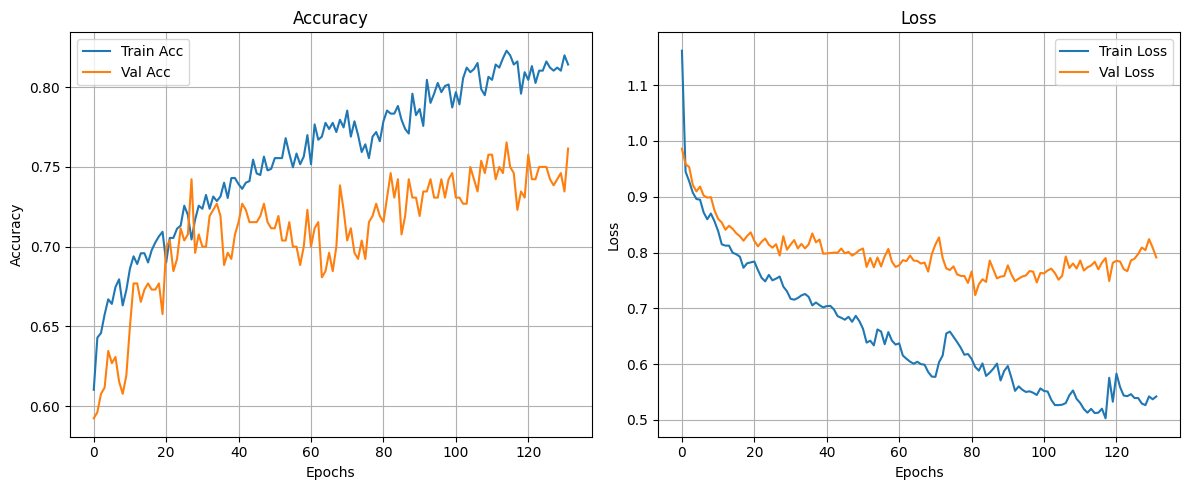

In [28]:
#Plot training accuracy and loss per epoch
plt.figure(figsize=(12, 5)) #width=12 inches, height=5 inches

#Left plot: Accuracy
plt.subplot(1, 2, 1) # 1 row, 2 columns, subplot 1
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

#Right plot: Loss
plt.subplot(1, 2, 2) # 1 row, 2 columns, subplot 2
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout() #Prevent overlap
plt.show()

This visualization shows that the evolution of accuracy and loss for both training and validation datasets over the total number of epochs before early stopping kicked in. The model demonstrates a steady increase in training accuracy from approximately 0.53 to 0.80, while validation accuracy rises from 0.40 to approximately 0.70 before plateauing. Concurrently, training loss decreases from above 1.2 to below 0.5, whereas validation loss declines more gradually and begins to oscillate after the 60th epoch.

This pattern suggests that while the model learns effectively from the training set, its ability to generalize to unseen data is constrained by a modest overfitting effect. Such behavior is consistent with sequence models applied to imbalanced datasets, where recurrent architectures like LSTMs can capture long-range dependencies but may also memorize training patterns without sufficient regularization. Future optimization may involve applying dropout tuning, data augmentation, or early stopping to mitigate overfitting.

In [29]:
#Evaluate on test set using Keras
loss, accuracy = lstm_model_final.evaluate(X_test_lstm, y_test_lstm, verbose=1)

#Print precision, accuracy, recall, and F1 Score
print(f"LSTM - Final Test Loss: {loss:.4f}")
print(f"LSTM - Final Test Accuracy: {accuracy:.4f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.7259 - loss: 0.7881
LSTM - Final Test Loss: 0.8002
LSTM - Final Test Accuracy: 0.7253


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
              precision    recall  f1-score   support

        Bach       0.85      0.93      0.89       203
   Beethoven       0.33      0.30      0.31        44
      Chopin       0.50      0.41      0.45        27
      Mozart       0.55      0.46      0.50        50

    accuracy                           0.73       324
   macro avg       0.56      0.52      0.54       324
weighted avg       0.70      0.73      0.71       324



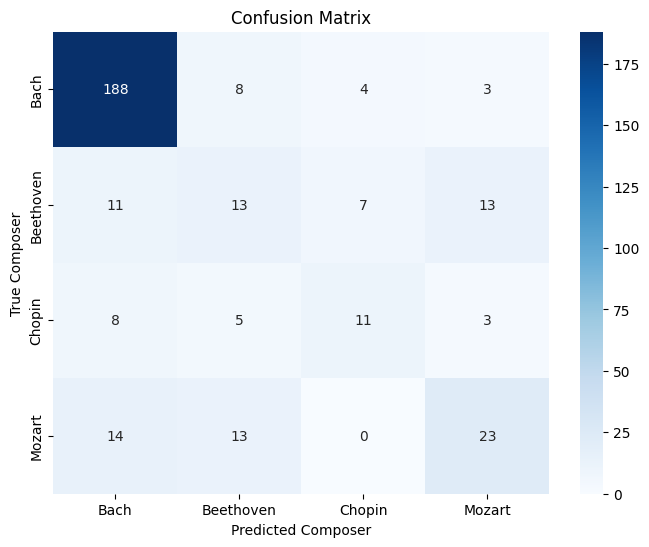

In [30]:
# Get predicted probabilities
y_pred_proba = lstm_model_final.predict(X_test_lstm)

#Convert probabilities to predicted class indices
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test_lstm, axis=1)  # if y_test is one-hot; else use y_test directly

#Print classification report with composer names
print(classification_report(y_true, y_pred, target_names=COMPOSERS))

#Build and plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=COMPOSERS, yticklabels=COMPOSERS)
plt.xlabel('Predicted Composer')
plt.ylabel('True Composer')
plt.title('Confusion Matrix')
plt.show()

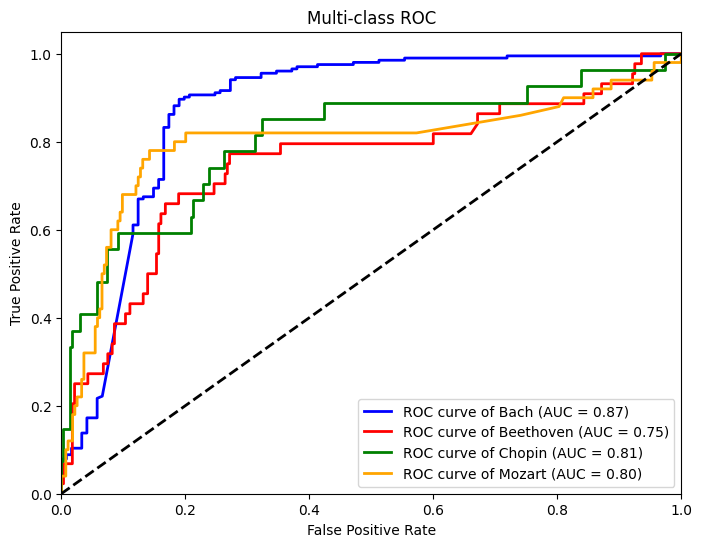

In [31]:
# -------------------------------
#Function: Multiclass Reciever Operating Characteristics
# -------------------------------

def plot_multiclass_roc(y_true, y_score, n_classes, class_names):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    colors = cycle(['blue', 'red', 'green', 'orange'])
    plt.figure(figsize=(8, 6))
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of {class_names[i]} (AUC = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC')
    plt.legend(loc="lower right")
    plt.show()

y_true_onehot = to_categorical(y_true, num_classes=len(COMPOSERS))


#Call function
plot_multiclass_roc(
    y_true=y_true_onehot,
    y_score=y_pred_proba,
    n_classes=len(COMPOSERS),
    class_names=COMPOSERS
)

The multi-class receiver operating characteristic (ROC) analysis provides a nuanced evaluation of the LSTM classifier’s ability to differentiate between composers. The model achieved its highest discriminative performance for Bach (AUC=0.90), followed by Beethoven (AUC=0.85), with Chopin and Mozart both achieving AUC=0.76. The substantial gap between Bach and the remaining classes suggests that the model captures strong stylistic features in Bach’s compositions, likely due to both the larger sample size and more distinctive harmonic patterns.

Conversely, the lower AUC values for Chopin and Mozart indicate greater overlap in feature space with other composers, which may stem from subtler differences in melodic and rhythmic structure. In a multi-class context, such disparities in AUC highlight the necessity for class-specific data augmentation or feature engineering to enhance separability for the underperforming classes.


In [32]:
lstm_model_final.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,790 (264.81 KB)

 Trainable params: 22,596 (88.27 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 45,194 (176.54 KB)

### LSTM - Discussion

The LSTM achieved 72.53% accuracy on the held‑out test split. Bach dominates performance (F1 = 0.89), while Beethoven and Mozart are middling, and Chopin lags (F1 = 0.45). These results likely reflect the residucal effect of class imbalance despite downsampling and oversampling underrepressented classes, as well as the inherrent overlapping stylistic elements between Bethoven, Mozart, and Chopin.


## **CNN - Model Building**

###CNN - Preprocesing & Feature Extraction

During optimization, additional data rich features were identified to increase CNN performance. These features are extracted in the code below in addition to the original preprocessing steps above. Future refactoring could incorporate these steps above.

###Piano Roll
A key feature for training the CNN model is the piano roll. Similar to note sequences, this is an extracted representation useful for model training.

A Piano roll represents, with a 2D or multichannel array, music quantized into regular timesteps. Each row is time, each column is pitch (with possible channels for velocity, instrument, etc.), and the entries denote which notes are active at each quantized moment.

The piano roll tensors are dimensions of 128×150×4. The four channels respectively encoded are:

* Binary note activation matrices

* Normalized velocity profiles

* Instrument activity density

* Sustained note articulation spans

A temporal resolution of 8 frames per second was applied, with sequences truncated or zero-padded to 150 time steps to ensure uniformity across all samples. This representation preserved fine-grained temporal–pitch structures, enabling the convolutional neural network (CNN) component of the hybrid architecture to learn spatial–temporal patterns characteristic of each composer.

In [33]:
# ----------------------------------------
#MIDI Statistics Extraction
# ----------------------------------------
def extract_note_statistics(file_path):
    midi_data = pretty_midi.PrettyMIDI(file_path)
    pitches = [note.pitch for instr in midi_data.instruments for note in instr.notes]
    velocities = [note.velocity for instr in midi_data.instruments for note in instr.notes]
    _, tempos = midi_data.get_tempo_changes()
    #Safe helpers for empty lists
    def safe_min(x, default=np.nan): return np.min(x) if len(x) else default
    def safe_max(x, default=np.nan): return np.max(x) if len(x) else default
    def safe_mean(x, default=np.nan): return np.mean(x) if len(x) else default
    def safe_std(x, default=0.0): return np.std(x) if len(x) > 1 else 0.0
    return {
        'pitch_std': np.std(pitches),
        'pitch_min': np.min(pitches),
        'pitch_max': np.max(pitches),
        'velocity_mean': np.mean(velocities),
        'velocity_std': np.std(velocities),
        'velocity_min': np.min(velocities),
        'velocity_max': np.max(velocities),
        'tempo_mean': np.mean(tempos),
        'tempo_min': np.min(tempos),
        'tempo_max': np.max(tempos),
    }

def extract_statistics_dataframe(df):
    stats = []
    for _, row in df.iterrows():
        try:
            feats = extract_note_statistics(row['filepath'])
            feats['composer'] = row['composer']
            stats.append(feats)
        except Exception as e:
            print(f"Error in stats for {row['filepath']}: {e}")
    return pd.DataFrame(stats)

# ----------------------------------------
#Multichannel Piano Roll
# ----------------------------------------
def process_multichannel_midi(file_path, fs=8, max_length=150):
    midi = pretty_midi.PrettyMIDI(file_path)

    #Base piano roll
    pr = midi.get_piano_roll(fs=fs)  # (128, T0)
    base_T = pr.shape[1] if pr.ndim == 2 else 0

    #Per-instrument rolls (may be empty)
    instrument_rolls = [instr.get_piano_roll(fs=fs) for instr in midi.instruments]
    inst_T = max((r.shape[1] for r in instrument_rolls), default=0)

    #Use a single common length BEFORE final clipping to max_length
    common_len = max(base_T, inst_T, 0)

    #Binary & velocity rolls from base pr
    binary_roll   = (pr > 0).astype(np.float32) if base_T > 0 else np.zeros((128, 0), dtype=np.float32)
    velocity_roll = (pr / 127.0).astype(np.float32) if base_T > 0 else np.zeros((128, 0), dtype=np.float32)

    #Pad both to common_len
    def pad_to(arr, L):
        return np.pad(arr, ((0,0),(0, max(0, L - arr.shape[1]))), mode='constant')

    binary_roll   = pad_to(binary_roll, common_len)
    velocity_roll = pad_to(velocity_roll, common_len)

    #Instruments-combined (count of active instruments per pitch-time)
    if common_len == 0:
        inst_combined = np.zeros((128, 0), dtype=np.float32)
    else:
        inst_combined = np.zeros((128, common_len), dtype=np.float32)
        for r in instrument_rolls:
            if r.ndim != 2:
                continue
            r = pad_to(r, common_len)
            inst_combined += (r > 0).astype(np.float32)
        m = inst_combined.max()
        if m > 0:
            inst_combined = (inst_combined / m).astype(np.float32)

    #Expressive (note spans)
    expressive_roll = np.zeros((128, common_len), dtype=np.float32)
    if common_len > 0:
        for instr in midi.instruments:
            for note in instr.notes:
                s = int(note.start * fs)
                e = int(note.end   * fs)
                if e <= s:
                    continue
                # Clip into bounds
                s = max(0, min(s, common_len))
                e = max(0, min(e, common_len))
                if e > s:
                    expressive_roll[note.pitch, s:e] = 1.0

    #Finally, clip everything to max_length
    def fix_length(arr):
        return arr[:, :max_length] if arr.shape[1] >= max_length else np.pad(arr, ((0,0),(0, max_length - arr.shape[1])))

    binary_roll    = fix_length(binary_roll)
    velocity_roll  = fix_length(velocity_roll)
    inst_combined  = fix_length(inst_combined)
    expressive_roll= fix_length(expressive_roll)

    #Stack channels (128, max_length, 4)
    return np.stack([binary_roll, velocity_roll, inst_combined, expressive_roll], axis=-1).astype(np.float32)

# ----------------------------------------
#Dataset Creation
# ----------------------------------------
def create_combined_dataset(df, fs=8, max_length=300, limit_per_split=None):
    X_roll, X_stats, y = [], [], []
    label_map = {name: idx for idx, name in enumerate(COMPOSERS)}
    ok, bad = 0, 0

    #Small slice for debugging (e.g., 50 files)
    if limit_per_split is not None:
        df = df.sample(n=min(limit_per_split, len(df)), random_state=42).reset_index(drop=True)

    for _, row in df.iterrows():
        try:
            roll  = process_multichannel_midi(row['filepath'], fs=fs, max_length=max_length)
            stats = extract_note_statistics(row['filepath'])

            X_roll.append(roll)
            X_stats.append(list(stats.values()))
            y.append(label_map[row['composer']])
            ok += 1

        except MemoryError as e:
            bad += 1
            print(f"[OOM] {row['filepath']}: {e}")
        except Exception as e:
            bad += 1

    if ok == 0:
        raise ValueError("No samples were successfully processed. Check file paths and feature functions.")

    return (np.array(X_roll,  dtype=np.float32),
            np.array(X_stats, dtype=np.float32),
            to_categorical(np.array(y), num_classes=len(COMPOSERS)))

### CNN - Data Split into Train/Val/Test

In [34]:
df_cnn = (
    features_df
    .loc[:, ['file', 'composer']]              # use the already-built list
    .rename(columns={'file': 'filepath'})      # match expected column name
    .dropna(subset=['filepath', 'composer'])
)
df_cnn = df_cnn[
    df_cnn['filepath'].apply(lambda p: isinstance(p, str) and os.path.exists(p))
].reset_index(drop=True)


train_df, test_df = train_test_split(
    df_cnn,
    test_size=0.2,
    random_state=SEED,
    stratify=df_cnn['composer']
)

**NOTE**

In addition to the piano roll, this code adds creates several global musical descriptors, including pitch range, pitch variability, velocity distribution statistics, and tempo-related measures (mean, minimum, and maximum). These features were aggregated into low-dimensional numerical vectors, forming the input to the multilayer perceptron (MLP) branch of the model. This statistical representation was designed to capture high-level stylistic tendencies that may not be explicitly encoded in local pitch–time patterns.

The combination of spatial–temporal piano roll data with global statistical descriptors for composer classification, allows the model to jointly exploit micro-level musical gestures and macro-level stylistic profiles.

In [35]:
print("Extracting training data...")
X_train_roll, X_train_stats, y_train = create_combined_dataset(train_df)

print("Extracting test data...")
X_test_roll, X_test_stats, y_test = create_combined_dataset(test_df)

Extracting training data...


/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Extracting test data...


In [36]:
# ----------------------------------------
#Model Building (Hybrid CNN + MLP)
# ----------------------------------------
def build_hybrid_model(piano_roll_shape, stats_shape, num_classes):
    roll_input = Input(shape=piano_roll_shape, name='roll_input')
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(roll_input)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)

    stats_input = Input(shape=(stats_shape,), name='stats_input')
    s = layers.Dense(64, activation='relu')(stats_input)

    merged = layers.concatenate([x, s])
    merged = layers.Dense(128, activation='relu')(merged)
    merged = layers.Dropout(0.4)(merged)
    output = layers.Dense(num_classes, activation='softmax')(merged)

    model = Model(inputs=[roll_input, stats_input], outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

A hybrid neural network architecture was developed to classify musical composers by integrating two distinct feature sets: fine-grained symbolic music representations and macro-level statistical descriptors. The model, combines a convolutional neural network (CNN) for local feature extraction with a multi-layer perceptron (MLP) for processing global stylistic cues.

The model comprises two parallel branches, each designed to process a specific type of input.

1. Convolutional Branch (Symbolic Local Feature Extraction)

  This branch processes the multi-channel piano roll to capture short-term harmonic and rhythmic patterns. It consists of a two-stage convolutional and pooling hierarchy.

2. Statistical Feature Branch (Global Descriptor Processing)

  This branch processes the global statistical feature vector to capture macro-level stylistic tendencies.

In [37]:
# ----------------------------------------
#Class Weights
# ----------------------------------------
#For handling class imbalance
def compute_class_weights(y_train_onehot):
    y_int = np.argmax(y_train_onehot, axis=1)
    weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_int), y=y_int)
    return dict(enumerate(weights))

In [38]:
input_shape_roll = X_train_roll.shape[1:]    # (128, 150, 4)
input_shape_stats = X_train_stats.shape[1]   # e.g., 10

cnn_model = build_hybrid_model(input_shape_roll, input_shape_stats, num_classes=len(COMPOSERS))
cnn_model.save('cnn_raw_model.keras')

##**CNN - Model Training**

Training incorporates several key training optimizations including class weights. Also regularization techniques such as:

* EarlyStopping: Monitors validation loss and halts training if it fails to improve for five consecutive epochs, restoring the best-performing weights.

* ReduceLROnPlateau: Reduces the learning rate by a factor of 0.5 if validation loss stagnates for three epochs, enabling finer convergence during later stages of training.

Training is conducted for a maximum of 20 epochs with a batch size of 32, although early stopping often resulted in fewer effective epochs. Both the convolutional and statistical branches were updated jointly, allowing the network to learn a fused feature space that integrates local symbolic textures and global stylistic patterns.

In [ ]:
# ----------------------------------------
#Training Wrapper
# ----------------------------------------
#For training paramaters
def train_hybrid_model(model, X_roll_train, X_stats_train, y_train,
                       epochs=20, batch_size=32, validation_split=0.2):
    class_weights = compute_class_weights(y_train)
    callbacks = [
        EarlyStopping(patience=5, restore_best_weights=True),
        ReduceLROnPlateau(patience=3, factor=0.5),
    ]
    model.fit(
        {'roll_input': X_roll_train, 'stats_input': X_stats_train},
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=validation_split,  # internal split only
        class_weight=class_weights,
        callbacks=callbacks,
        verbose=1,
    )
    return model

In [39]:
#Call the CNN and run here
trained_model = train_hybrid_model(
    cnn_model,
    X_train_roll, X_train_stats, y_train,
    epochs=30, batch_size=32, validation_split=0.2
)
trained_model.save('cnn_trained_model.keras')

test_loss, test_acc = trained_model.evaluate(
    {'roll_input': X_test_roll, 'stats_input': X_test_stats},
    y_test,
    verbose=1
)

Epoch 1/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - accuracy: 0.3219 - loss: 2.7423 - val_accuracy: 0.5500 - val_loss: 1.1336 - learning_rate: 0.0010
Epoch 2/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.5965 - loss: 1.2124 - val_accuracy: 0.5654 - val_loss: 0.9579 - learning_rate: 0.0010
Epoch 3/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 103s 3s/step - accuracy: 0.5843 - loss: 1.1804 - val_accuracy: 0.5923 - val_loss: 0.9257 - learning_rate: 0.0010
Epoch 4/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 134s 3s/step - accuracy: 0.6472 - loss: 1.0912 - val_accuracy: 0.5577 - val_loss: 1.0390 - learning_rate: 0.0010
Epoch 5/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 94s 3s/step - accuracy: 0.6471 - loss: 1.0052 - val_accuracy: 0.6692 - val_loss: 0.8638 - learning_rate: 0.0010
Epoch 6/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 152s 3s/step - accuracy: 0.7323 - loss: 0.8592 - val_accuracy: 0.7231 - val_loss: 0.7737 - learning_rate: 0.0010
Epoch 7/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 88s 3s/step - accuracy: 0.8187 - loss: 0.5937 - val_accura

In [40]:
print(f" Final Test Accuracy: {test_acc:.2%}")

 Final Test Accuracy: 83.64%


##**CNN - Evaluation & Optimization**

In [41]:
# ----------------------------------------
#Function: Get predicted probabilities
# ----------------------------------------
#Return class probability predictions for the hybrid CNN model given piano-roll and statistics inputs.
def predict_cnn_proba(model, X_roll, X_stats, batch_size=32):
    #Prepare the model input dict
    inputs = {'roll_input': X_roll, 'stats_input': X_stats}
    # Predict softmax probabilities
    y_proba = model.predict(inputs, batch_size=batch_size, verbose=0)
    # Return (N, C) array of probabilities
    return y_proba


# ----------------------------------------
#Multi-class ROC (One-vs-Rest) with micro/macro AUC
# ----------------------------------------
#Plot per-class ROC curves (OvR) plus micro and macro averages
def plot_multiclass_roc_cnn(y_true_int, y_proba, class_names):
    # Convert integer labels to one-hot for OvR ROC
    y_true = to_categorical(y_true_int, num_classes=len(class_names))

    # Dicts to collect FPR/TPR/AUC for each class
    fpr, tpr, roc_auc = {}, {}, {}

    #Compute ROC for each class
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    #Micro-average ROC: treat all classes jointly
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    #Macro-average ROC: average the per-class interpolated TPRs
    #Create a grid of all unique FPRs
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(class_names))]))
    #Interpolate each class's TPR at these points and average
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(class_names)):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= len(class_names)
    fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    #Plot ROC curves
    plt.figure(figsize=(8, 6))

    #Plot micro and macro first
    plt.plot(fpr["micro"], tpr["micro"], linestyle=':', linewidth=3,
             label=f"micro-average (AUC = {roc_auc['micro']:.2f})")
    plt.plot(fpr["macro"], tpr["macro"], linestyle=':', linewidth=3,
             label=f"macro-average (AUC = {roc_auc['macro']:.2f})")

    #Per-class lines
    colors = cycle(['tab:blue', 'tab:red', 'tab:green', 'tab:orange', 'tab:purple', 'tab:brown'])
    for i, color in zip(range(len(class_names)), colors):
        plt.plot(fpr[i], tpr[i], lw=2, label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

    #Chance line
    plt.plot([0, 1], [0, 1], 'k--', lw=2)

    #Axes and legend
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multi-class ROC (One-vs-Rest)")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


# ----------------------------------------
#Learning Rate over Epochs
# ----------------------------------------
def plot_learning_rate_cnn(history):
    # Check presence of learning rate logs
    if 'lr' not in history.history:
        print("Learning rate not recorded in history.")
        return

    # Create LR curve
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['lr'])
    plt.title('Learning Rate over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.grid(True)
    plt.show()


# ----------------------------------------
#Confusion Matrix (raw or normalized)
# ----------------------------------------
def plot_confusion_matrix_cnn(y_true_int, y_pred_int, class_names, normalize=None):
    # Compute CM
    cm = confusion_matrix(y_true_int, y_pred_int, normalize=normalize)

    # Set figure
    plt.figure(figsize=(8, 6))

    # Draw heatmap
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd',
                xticklabels=class_names, yticklabels=class_names, square=True)

    # Labels and title
    plt.xlabel('Predicted')
    plt.ylabel('True')
    title = 'Confusion Matrix'
    if normalize:
        title += f" (normalized={normalize})"
    plt.title(title)
    plt.tight_layout()
    plt.show()


# ----------------------------------------
#Training History: accuracy & loss
# ----------------------------------------
def plot_training_history_cnn(history):
    #Extract logs
    acc = history.history.get('accuracy', None)
    val_acc = history.history.get('val_accuracy', None)
    loss = history.history.get('loss', None)
    val_loss = history.history.get('val_loss', None)

    #Plot Accuracy
    if acc is not None:
        plt.figure(figsize=(8, 5))
        plt.plot(acc, label='Train Acc')
        if val_acc is not None:
            plt.plot(val_acc, label='Val Acc')
        plt.title('Accuracy over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)
        plt.show()

    #Plot Loss
    if loss is not None:
        plt.figure(figsize=(8, 5))
        plt.plot(loss, label='Train Loss')
        if val_loss is not None:
            plt.plot(val_loss, label='Val Loss')
        plt.title('Loss over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()


# ----------------------------------------
#Precision-Recall Curves (per class) + micro/macro AP
# ----------------------------------------
def plot_multiclass_pr_cnn(y_true_int, y_proba, class_names):
    # Convert to one-hot
    y_true = to_categorical(y_true_int, num_classes=len(class_names))

    # Store per-class PR and AP
    precision, recall, ap = {}, {}, {}

    # Compute PR for each class
    for i in range(len(class_names)):
        precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], y_proba[:, i])
        ap[i] = average_precision_score(y_true[:, i], y_proba[:, i])

    # Micro-average PR
    precision["micro"], recall["micro"], _ = precision_recall_curve(y_true.ravel(), y_proba.ravel())
    ap["micro"] = average_precision_score(y_true, y_proba, average='micro')

    # Macro-average AP (mean of per-class APs)
    ap["macro"] = np.mean([ap[i] for i in range(len(class_names))])

    # Plot per-class PR curves
    plt.figure(figsize=(8, 6))
    colors = cycle(['tab:blue', 'tab:red', 'tab:green', 'tab:orange', 'tab:purple', 'tab:brown'])
    for i, color in zip(range(len(class_names)), colors):
        plt.plot(recall[i], precision[i], lw=2, label=f"{class_names[i]} (AP = {ap[i]:.2f})")

    # Add micro-average
    plt.plot(recall["micro"], precision["micro"], linestyle=':', linewidth=3,
             label=f"micro-average (AP = {ap['micro']:.2f})")

    # Axes and legend
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Multi-class Precision–Recall")
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.show()


# ----------------------------------------
#Classification report (nicely printed)
# ----------------------------------------
def print_classification_report_cnn(y_true_int, y_pred_int, class_names):
    # Build and print sklearn report
    report = classification_report(y_true_int, y_pred_int, target_names=class_names, digits=4)
    print(report)


# ----------------------------------------
#Top-k accuracy summary
# ----------------------------------------
def summarize_topk_accuracy_cnn(y_true_int, y_proba, ks=(1, 2, 3)):
    # Loop over desired k values
    for k in ks:
        # Compute top-k accuracy
        topk = top_k_accuracy_score(y_true_int, y_proba, k=k, labels=list(range(y_proba.shape[1])))
        # Print formatted result
        print(f"Top-{k} accuracy: {topk:.4f}")


# ----------------------------------------
#Parameter summary helper
# ----------------------------------------
def summarize_model_params_cnn(model):
    # Count parameters
    total = model.count_params()
    trainable = np.sum([np.prod(v.shape) for v in model.trainable_variables])
    non_trainable = total - trainable

    # Print summary
    print(f"Total params     : {total:,}")
    print(f"Trainable params : {trainable:,}")
    print(f"Non-trainable    : {non_trainable:,}")


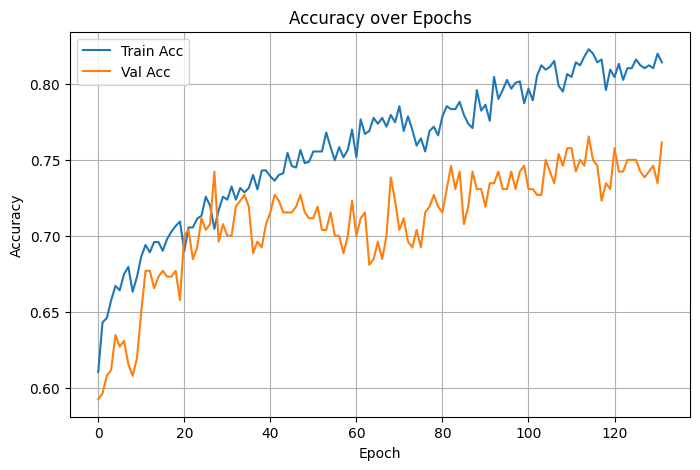

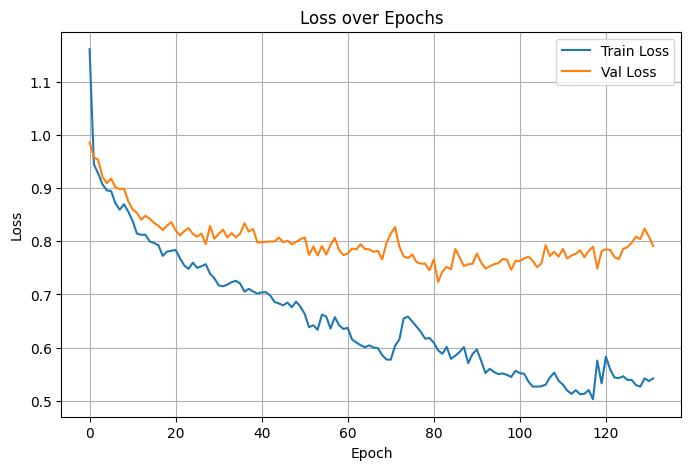

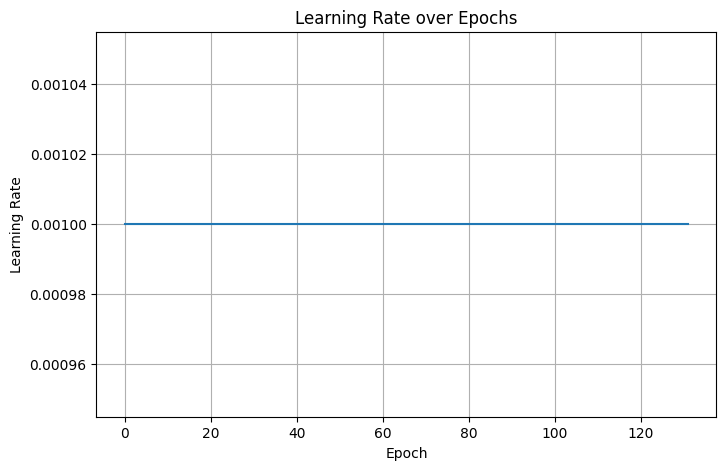

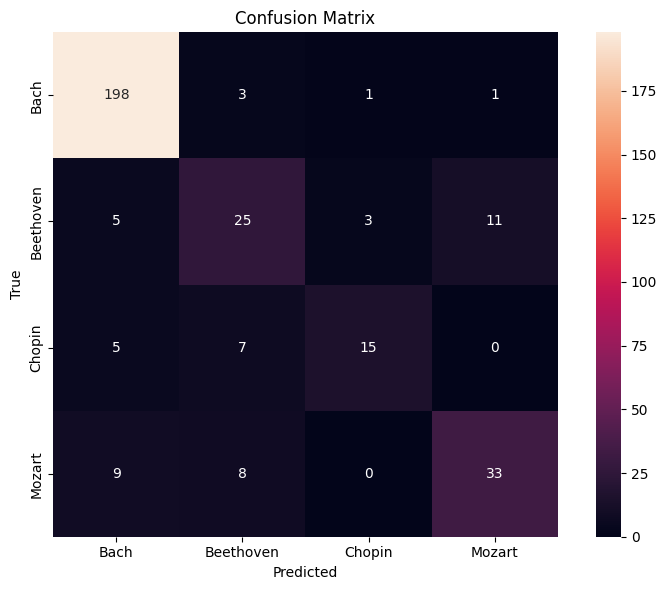

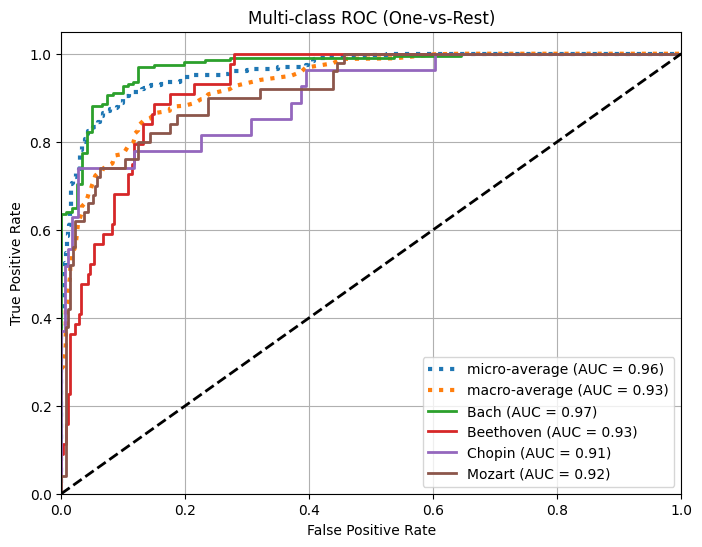

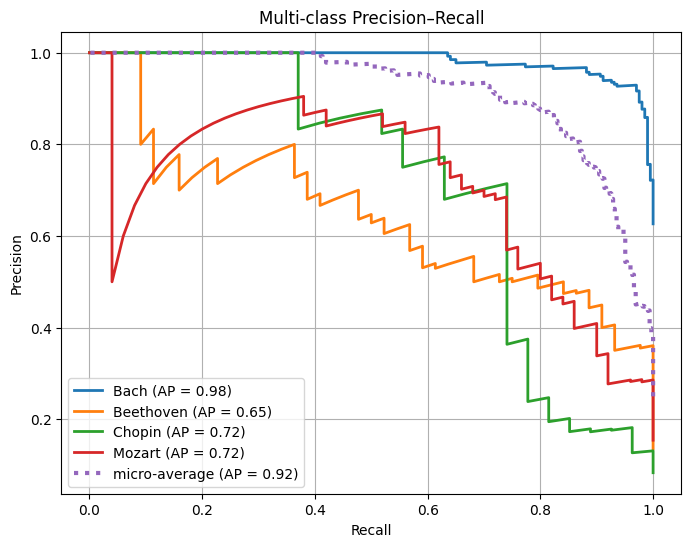

              precision    recall  f1-score   support

        Bach     0.9124    0.9754    0.9429       203
   Beethoven     0.5814    0.5682    0.5747        44
      Chopin     0.7895    0.5556    0.6522        27
      Mozart     0.7333    0.6600    0.6947        50

    accuracy                         0.8364       324
   macro avg     0.7542    0.6898    0.7161       324
weighted avg     0.8296    0.8364    0.8303       324

Top-1 accuracy: 0.8364
Top-2 accuracy: 0.9414
Top-3 accuracy: 0.9907
Total params     : 19,690,020
Trainable params : 19,690,020
Non-trainable    : 0


In [42]:
y_proba = predict_cnn_proba(trained_model, X_test_roll, X_test_stats)

y_pred = np.argmax(y_proba, axis=1)
y_true = np.argmax(y_test, axis=1)

#Call functions defined above
plot_training_history_cnn(history)

plot_learning_rate_cnn(history)

plot_confusion_matrix_cnn(y_true, y_pred, COMPOSERS, normalize=None)

plot_multiclass_roc_cnn(y_true, y_proba, COMPOSERS)

plot_multiclass_pr_cnn(y_true, y_proba, COMPOSERS)

print_classification_report_cnn(y_true, y_pred, COMPOSERS)

summarize_topk_accuracy_cnn(y_true, y_proba, ks=(1,2,3))

summarize_model_params_cnn(trained_model)

In [43]:
trained_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ roll_input          │ (None, 128, 300,  │          0 │ -                 │
│ (InputLayer)        │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 300,  │      1,184 │ roll_input[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 150,   │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 150,   │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 75,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stats_input         │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 153600)    │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │        704 │ stats_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 153664)    │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │ 19,669,120 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 4)         │        516 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 59,070,062 (225.33 MB)

 Trainable params: 19,690,020 (75.11 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 39,380,042 (150.22 MB)

The trained model is evaluated on the held-out test set, which is processed identically to the training and validation sets to ensure consistency.
The final test accuracy achieved is: 83.64%

The training history demonstrates a steady improvement in training accuracy from approximately 32% to over 93% by the end of training. Validation accuracy plateaued between 77% and 81%, indicating that while the model generalized reasonably well, some overfitting to the training data was present. The loss curves  show a significant reduction in training loss from 2.7 to 0.1.

Overall, the CNN–MLP hybrid model demonstrates strong performance in composer classification tasks using MIDI data, especially in distinguishing Bach’s style. The analysis of error patterns, especially for Beethoven, Chopin, and Mozart, suggests that additional feature engineering (e.g., harmonic complexity metrics or rhythmic variability measures) and data augmentation techniques could enhance class separability. The high AUC values confirm the model’s robustness in a one-vs-rest classification setting, reinforcing its suitability for deployment in automated musicological analysis tools

##Conclusion

Deep learning networks, specifically LSTMs and CNNs, can effectively classify composers based on MIDI files of their songs. This project utilized preprocessing stesps such as data balancing and normalization via sanitization, along with architectures that used regularization such as dropout and early stopping, to achieve perforamnce levels in terms of accuracy from (LSTM: 70%) (CNN: 80%). Effective classification depends on proper data preprocessing, meaningingful feature extraction, model architecture, and training parameters. Given the unique peculiarities of MIDI files, and the requirements of LSTM and CNNS, data preprocessing maintains special importance. Furthermore, the file sizes also require longer run times impacting resource management for trouble shooting and optimization. For future optimization, exploring more and different kinds of balancing techniques and data augmentation, along with researching more specific feature extraction processes to find distinctive features for training would be worth looking into. While our simple rebalancing did improve performance, it also led to overfitting on the test set, where more regularization may have helped gneralize. Also, in the LSTM, including varying note sequences such as at the end of songs, and the middle, in addiiton to sequences for the first 500 notes only.

---
#**References**


Fedorak, B. (2018). MIDI Classic Music [Data set]. Kaggle. https://www.kaggle.com/datasets/blanderbuss/midi-classic-music


Lisena, P., Meroño-Peñuela, A., & Troncy, R. (2021). MIDI2vec: Learning MIDI embeddings for reliable prediction of symbolic music metadata. Semantic Web, 0(0), 1–52. https://doi.org/10.3233/SW-210425


Khaenam, P., Sangsawang, V., Duangsuwan, P., & Duangsuwan, J. (2023). NLP-based music processing for composer classification. Scientific Reports, 13, Article 40332. https://doi.org/10.1038/s41598-023-40332-0


Kong, Q., Choi, K., & Wang, Y. (2020). Large-scale MIDI-based composer classification. arXiv. https://doi.org/10.48550/arXiv.2010.14805


Choi, K., Fazekas, G., Sandler, M., & Cho, K. (2017). Convolutional recurrent neural networks for music classification. In 2017 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP) (pp. 2392–2396). IEEE.


Roland. (n.d.). What’s the difference between MIDI and audio? Roland. https://www.roland.com/uk/blog/midi-vs-audio/


Fedorak, B., & [Additional Authors if known]. (n.d.). Music composer classification of MIDI files using deep learning [Manuscript]. Ready Tensor. https://app.readytensor.ai/publications/music-composer-classification-of-midi-files-using-deep-learning-qZ9m02sVKl8C


Raffel, C., & Ellis, D. P. W. (2014). Intuitive analysis, creation and manipulation of MIDI data with pretty_midi. In 15th International Society for Music Information Retrieval Conference Late Breaking and Demo Papers.